In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras  import models, layers
import matplotlib.pyplot as plt

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPCOHS = 50

In [5]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Potato/Plant Village",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 1614 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['Early_Blight', 'Healthy', 'Late_Blight']

(32, 256, 256, 3)
[0 0 0 1 1 0 0 1 0 0 1 0 1 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]


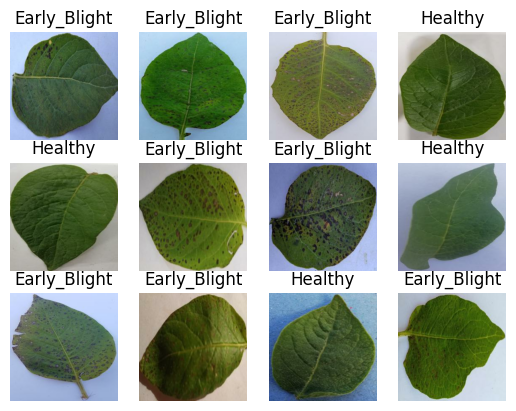

In [7]:
#To convert into numpy array
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    for  i in  range (12):
        ax =plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")


Splitting Train Test Split

In [8]:
def get_dataset_partitions(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + val_split + test_split) == 1, "Splits must sum to 1"

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(min(shuffle_size, ds_size), seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)

    return train_ds, val_ds, test_ds


In [9]:
train_ds, val_ds, test_ds=get_dataset_partitions(dataset)

In [10]:
len(train_ds)

40

In [11]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds= val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
#normalization and resizing images
resize_and_rescale = tf.keras.Sequential([
    tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [13]:
#ogmentation
data_agumentation =tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical",  input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    layers.RandomRotation(0.2)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
inputs_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)  # No need for batch size

n_classes = 3
# Define the CNN model
model = models.Sequential([
    resize_and_rescale,
    data_agumentation,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=inputs_shape),  # Add input_shape here
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.compile(
    optimizer= 'adam',
    loss =tf.keras.losses.SparseCategoricalCrossentropy(from_logits='Flase'),
    metrics =['accuracy'],
)

In [17]:
history = model.fit(
    train_ds,
    batch_size= BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs= EPCOHS
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


40/40 ━━━━━━━━━━━━━━━━━━━━ 265s 221ms/step - accuracy: 0.7276 - loss: 0.6492 - val_accuracy: 0.7625 - val_loss: 0.5358
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8053 - loss: 0.4943 - val_accuracy: 0.7625 - val_loss: 0.5124
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8076 - loss: 0.4393 - val_accuracy: 0.7875 - val_loss: 0.4441
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8642 - loss: 0.3438 - val_accuracy: 0.8000 - val_loss: 0.4203
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.8501 - loss: 0.3557 - val_accuracy: 0.8687 - val_loss: 0.2934
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.8858 - loss: 0.3139 - val_accuracy: 0.9438 - val_loss: 0.1638
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9383 - loss: 0.2106 - val_accuracy: 0.9187 - val_loss: 0.2394
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9200 - loss: 0.2155 - val_accuracy: 0.9563 - val_loss:

In [18]:
scores =model.evaluate(test_ds)

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9828 - loss: 0.0610


In [20]:
scores

[0.06797973066568375, 0.9791666865348816]

{'verbose': 1, 'epochs': 50, 'steps': 40}